# Time Series Forecasting with DeepAR

DeepAR is a supervised learning algorithm for forecasting scalar time series. <br>
This notebook demonstrates how to prepare a dataset of time series for training DeepAR and how to use the trained model for inference.

### Importing Modules

In [ ]:
import boto3, s3fs, io, json, time
import sagemaker

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# The S3 bucket prefix that you want to use for training and model data.
sess = sagemaker.Session()
bucket = "" # name of the bucket
prefix = "" # prefix
region = sess.boto_region_name

role = sagemaker.get_execution_role()

### Reading data

In [ ]:
df = pd.read_csv('item-demand-time-train.csv', names=['timestamp','target_value','item_id'])
df.head() # Show the first 5 rows

,timestamp,target_value,item_id
0,2014-01-01 01:00:00,38.349917,client_12
1,2014-01-01 02:00:00,33.582090,client_12
2,2014-01-01 03:00:00,34.411277,client_12
3,2014-01-01 04:00:00,39.800995,client_12
4,2014-01-01 05:00:00,41.044776,client_12


In [ ]:
df.info() #  Print a concise summary of a DataFrame - Including Dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21885 entries, 0 to 21884
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     21885 non-null  object 
 1   target_value  21885 non-null  float64
 2   item_id       21885 non-null  object 
dtypes: float64(1), object(2)
memory usage: 513.1+ KB


### Data Processing

#### Preparing the data for the algorithm 

Timestamp column Dtype = object. <br> 
Should be converted to datetime.

In [ ]:
df["timestamp"] = pd.to_datetime(df["timestamp"]) # converting "timestamp" column Dtype to datetime

In [ ]:
df.info() # rechecking the Dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21885 entries, 0 to 21884
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     21885 non-null  datetime64[ns]
 1   target_value  21885 non-null  float64       
 2   item_id       21885 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 513.1+ KB


#### Slicing the targeted client data 

In [ ]:
client_id = 'client_12' # example
temp_df = df[["timestamp", "target_value"]][df['item_id'] == client_id]

In [ ]:
temp_df.head()

,timestamp,target_value
0,2014-01-01 01:00:00,38.349917
1,2014-01-01 02:00:00,33.582090
2,2014-01-01 03:00:00,34.411277
3,2014-01-01 04:00:00,39.800995
4,2014-01-01 05:00:00,41.044776


#### Setting timestamp column as index

In [ ]:
temp_df.set_index(["timestamp"], inplace=True)
temp_df.head()

,target_value
timestamp,
2014-01-01 01:00:00,38.349917
2014-01-01 02:00:00,33.582090
2014-01-01 03:00:00,34.411277
2014-01-01 04:00:00,39.800995
2014-01-01 05:00:00,41.044776


In [ ]:
idx = pd.date_range(df.timestamp.min(), df.timestamp.max(), freq='H') # making sure the data is well arranged 
temp_df = temp_df.reindex(idx, fill_value=0)

#### Form a list from the dataframe

In [ ]:
#temp_df_test = temp_df.resample("2H").sum() # / 2 for the average ## Uncomment if resample needed

num_timeseries = temp_df.shape[1]
timeseries = [] 
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(temp_df.iloc[:, i], trim='fb'))

In [ ]:
print(timeseries)
print("Dtype is ", type(timeseries))

[2014-01-01 01:00:00     38.349917
2014-01-01 02:00:00     33.582090
2014-01-01 03:00:00     34.411277
2014-01-01 04:00:00     39.800995
2014-01-01 05:00:00     41.044776
                          ...    
2014-10-31 19:00:00    151.119403
2014-10-31 20:00:00    127.280265
2014-10-31 21:00:00     72.139303
2014-10-31 22:00:00     44.776119
2014-10-31 23:00:00     48.507463
Freq: H, Name: target_value, Length: 7295, dtype: float64]
Dtype is  <class 'list'>


In [ ]:
testing_length = 168 # Number of points to be tested on 

time_series_training = [] # defining a list for training
for ts in timeseries:
    time_series_training.append(ts[:-testing_length])

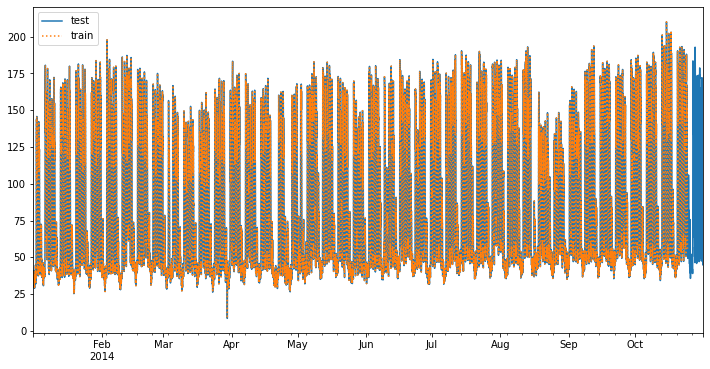

In [ ]:
plt.figure(figsize=(12, 6))
timeseries[0].plot(label="test") # plotting the series for train and the series for test
time_series_training[0].plot(label="train", ls=":")
plt.legend()
plt.show()

#### Saving the the training and the testing sets in S3 as json files 

In [ ]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj


def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

encoding = "utf-8"
FILE_TRAIN = "train.json"
FILE_TEST = "test.json"
with open(FILE_TRAIN, "wb") as f:
    for ts in time_series_training:
        f.write(series_to_jsonline(ts).encode(encoding))
        f.write("\n".encode(encoding))

with open(FILE_TEST, "wb") as f:
    for ts in timeseries:
        f.write(series_to_jsonline(ts).encode(encoding))
        f.write("\n".encode(encoding))

s3 = boto3.client("s3")
s3.upload_file(FILE_TRAIN, bucket, prefix + "/train/" + FILE_TRAIN)
s3.upload_file(FILE_TEST, bucket, prefix + "/test/" + FILE_TEST)

### Retrieving "forecasting-DeepAR" image

#### Define the estimator that will launch the training job

In [ ]:
from sagemaker.image_uris import retrieve
image_uri = retrieve(framework="forecasting-deepar", 
                     region=boto3.Session().region_name)

s3_output_path = f"{bucket}/{prefix}/output"

estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sess,
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    base_job_name="DEMO-deepar",
    output_path=f"s3://{s3_output_path}", # S3 location for saving the training result (model artifacts and output files)
)

#### Set Hyperparameters

In [ ]:
freq="H" 
context_length = 168 # Context of the time series the model should take into account when making the prediction
prediction_length = 168 # number of points to be predicted

hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10" }

estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job.<br> SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

In [ ]:
s3_data_path = f"{bucket}/{prefix}"

data_channels = {"train": f"s3://{s3_data_path}/train/", "test": f"s3://{s3_data_path}/test/"}

estimator.fit(inputs=data_channels)

2022-01-18 07:51:10 Starting - Starting the training job...
2022-01-18 07:51:12 Starting - Launching requested ML instancesProfilerReport-1642492270: InProgress
......
2022-01-18 07:52:38 Starting - Preparing the instances for training.........
2022-01-18 07:53:58 Downloading - Downloading input data
2022-01-18 07:53:58 Training - Downloading the training image.....Arguments: train
[01/18/2022 07:54:49 INFO 139671049450880] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples': '100', 'num_layers': '2', 'test_quantiles': '[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]'}
[01/18/202

### Create Endpoint and Predictor

Now that we have trained a model, we can use it to perform predictions by deploying it to an endpoint.

In [ ]:
job_name = estimator.latest_training_job.name

endpoint_name = sess.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    image_uri=image_uri,
    role=role,
)

-------!

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using pandas.Series objects rather than raw JSON strings.

In [ ]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.

        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points

        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length

    def predict(
        self,
        ts,
        cat=None,
        encoding="utf-8",
        num_samples=100,
        quantiles=["0.1", "0.5", "0.9"],
        content_type="application/json",
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1] + pd.Timedelta(1, unit=self.freq) for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req, initial_args={"ContentType": content_type})
        return self.__decode_response(res, prediction_times, encoding)

    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles"],
            "quantiles": quantiles,
        }
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)

    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(
                start=prediction_times[k], freq=self.freq, periods=self.prediction_length
            )
            list_of_df.append(
                pd.DataFrame(
                    data=response_data["predictions"][k]["quantiles"], index=prediction_index
                )
            )
        return list_of_df

In [ ]:
predictor = DeepARPredictor(endpoint_name=endpoint_name, sagemaker_session=sess)
predictor.set_prediction_parameters(freq, prediction_length)

### Make predictions and plot results

#### Now we can use the previously created predictor object.

In [ ]:
list_of_df = predictor.predict(time_series_training[:5], content_type="application/json")
actual_data = timeseries[:5]

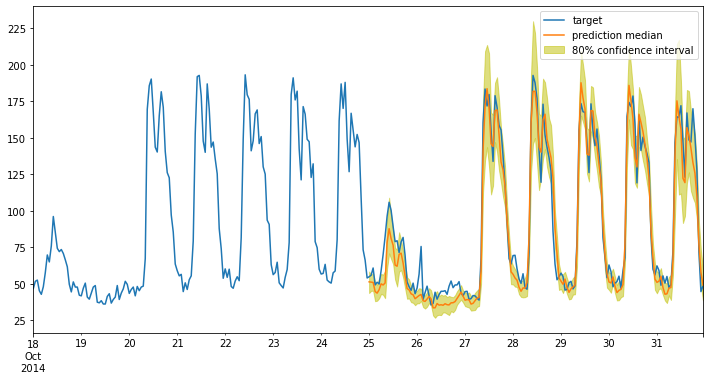

In [ ]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12, 6))
    actual_data[k][-prediction_length - context_length :].plot(label="target")
    p10 = list_of_df[k]["0.1"]
    p90 = list_of_df[k]["0.9"]
    plt.fill_between(p10.index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
    list_of_df[k]["0.5"].plot(label="prediction median")
    plt.legend()
    plt.show()

### Clean UP

In [ ]:
predictor.delete_model()
predictor.delete_endpoint()